In [616]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utilitiy functions

In [617]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def stc_pass(inputs, layer, n):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = tf.reshape(Bernoulli(probs=z,dtype=tf.float32).sample(n), [n*n*batch_size,nh])
    z = add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid)
    z = tf.reduce_mean(tf.reshape(z,[n,n*batch_size,392]), 0) if layer==1 else z
    z = prob(z, tf.tile(y_,[n,1]))
    z_expect = tf.reduce_mean(tf.reshape(z, [n,batch_size,392]), 0)
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-z_expect-eps, [n,1])), 1, keep_dims=True), z_expect

def fg_cov(f, g, w, n):
    f, g = [tf.reshape(z, [n,batch_size,nh]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mf, mg = [df, dg] if i==0 else [mf+df, mg+dg]
        vg = tf.square(dg) if i==0 else vg+tf.square(dg)
        cov = df*dg if i==0 else cov+df*dg
    return mf/n, mg/n, (cov-mf*mg/n)/(n-1), (vg-tf.square(mg)/n)/(n-1)

def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, nh]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

### Parameters

In [618]:
batch_size = 4
lr = 1e-3
eps = 1e-7
alpha = 0.9
nh = 100

### Graph

In [619]:
def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    return tf.matmul(inputs, w) + b if af is None else af(tf.matmul(inputs, w) + b)

prob = lambda p, s: s*p+(1.0-s)*(1.0-p)
log_prob = lambda p, s: tf.log(tf.clip_by_value(prob(p, s), eps, 1.0-eps))

ns = tf.placeholder(tf.int32)

x   = tf.placeholder(tf.float32, [None, 392])
h   = add_layer(x, "wxh", "bxh", 392, 100, tf.nn.sigmoid)
sh  = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [-1,100]))
h2  = add_layer(sh, "whh", "bhh", 100, 100, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [-1,100]))
y   = add_layer(sh2, "why", "bhy", 100, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, -1, 392]), 0)
y_  = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(prob(y, tf.tile(y_,[ns**2,1]))/
                    tf.stop_gradient(tf.tile(-prob(y_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
ls  = tf.reduce_mean(tf.reshape(ls2, [ns,-1, 1]), 0)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

opt = tf.train.AdamOptimizer(lr)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]
dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls2)*log_prob(_h2, sh2), 0), 
                            get_weights("whh", "bhh"))        
dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls)*log_prob(_h, sh), 0),
                            get_weights("wxh", "bxh"))
gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
train_step = opt.apply_gradients(gd)

In [620]:
def det_pass(inputs, layer, n, _expect):
    if layer==1:
        inputs = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
    z = prob(add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-_expect-eps,[n,1])), 1, keep_dims=True)

def muProp(p, s, layer, _expect):
    fh = det_pass(p, layer, ns**(layer-1), prob(_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

g2, mg2 = muProp(h2, sh2, 2, y_expect)
g, mg = muProp(h, sh, 1, y_expect)

mpdh2 = tf.gradients(tf.reduce_mean(tf.stop_gradient(g2)*log_prob(_h2, sh2), 0)-
                     tf.reduce_mean(mg2, 0), get_weights("whh", "bhh")) 
mpdh  = tf.gradients(tf.reduce_mean(tf.stop_gradient(g)*log_prob(_h, sh), 0)-
                     tf.reduce_mean(mg, 0), get_weights("wxh", "bxh"))

mpgd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]

mpgd[2][0] -= mpdh2[0]
mpgd[3][0] -= mpdh2[1]
mpgd[4][0] -= mpdh[0] 
mpgd[5][0] -= mpdh[1]
mptrain_step = opt.apply_gradients(mpgd)

In [621]:
_why = tf.placeholder(tf.float32,[100, 392])
_bhy = tf.placeholder(tf.float32,[  1, 392])
_whh = tf.placeholder(tf.float32,[100, 100])
_bhh = tf.placeholder(tf.float32,[  1, 100])
_wxh = tf.placeholder(tf.float32,[392, 100])
_bxh = tf.placeholder(tf.float32,[  1, 100])

gd_why = tf.placeholder(tf.float32,[100, 392])
gd_bhy = tf.placeholder(tf.float32,[  1, 392])
gd_whh = tf.placeholder(tf.float32,[100, 100])
gd_bhh = tf.placeholder(tf.float32,[  1, 100])
gd_wxh = tf.placeholder(tf.float32,[392, 100])
gd_bxh = tf.placeholder(tf.float32,[  1, 100])

plh  = tf.nn.sigmoid(tf.matmul(x, _wxh)+_bxh)
plsh = tf.stop_gradient(tf.reshape(Bernoulli(probs=plh, dtype=tf.float32).sample(ns), [-1,100]))
plh2  = tf.nn.sigmoid(tf.matmul(plsh, _whh)+_bhh)
plsh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=plh2, dtype=tf.float32).sample(ns), [-1,100]))

def cv_gd(x, w1, s1, w2, s2, w3):
    lh  = tf.nn.sigmoid(tf.matmul( x,w1[0])+w1[1])
    lh2 = tf.nn.sigmoid(tf.matmul(s1,w2[0])+w2[1])
    ly  = tf.nn.sigmoid(tf.matmul(s2,w3[0])+w3[1])
    ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

    lnll = tf.reduce_mean(tf.reduce_sum(-log_prob(ly_expect, y_), 1))
    lls2 = tf.reduce_sum(prob(ly, tf.tile(y_,[ns**2,1]))/
                         tf.stop_gradient(tf.tile(-prob(ly_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
    lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)
    _lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]

    l2 = tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, s2), 0)
    l1 = tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, s1), 0)
    
    return lnll, l2, l1, ly_expect, lh, lh2

_nll, _ls2, _ls, ply_expect, lh, lh2 = cv_gd(x, get_weights("wxh","bxh"), 
                                             plsh, get_weights("whh","bhh"), 
                                             plsh2, get_weights("why","bhy"))
dly  = opt.compute_gradients(_nll, get_weights("why","bhy"))
dlh2 = opt.compute_gradients(_ls2, get_weights("whh","bhh"))
dlh  = opt.compute_gradients( _ls, get_weights("wxh","bxh"))
ggd = [list(i) for i in dly] + [list(i) for i in dlh2] + [list(i) for i in dlh]


In [622]:
_g2, _mg2 = muProp(lh2, plsh2, 2, ply_expect)
_g, _mg = muProp(lh, plsh, 1, ply_expect)
_lh2, _lh = [tf.tile(z,[ns,1]) for z in [lh2, lh]]
plmpdh2 = tf.gradients(tf.reduce_mean(tf.stop_gradient(_g2)*log_prob(_lh2, plsh2), 0)-
                     tf.reduce_mean(_mg2, 0), get_weights("whh", "bhh")) 
plmpdh  = tf.gradients(tf.reduce_mean(tf.stop_gradient(_g)*log_prob(_lh, plsh), 0)-
                     tf.reduce_mean(_mg, 0), get_weights("wxh", "bxh"))

ggd[2][0] -= plmpdh2[0]
ggd[3][0] -= plmpdh2[1]
ggd[4][0] -= plmpdh[0]
ggd[5][0] -= plmpdh[1]

gtrain_step = opt.apply_gradients(ggd)

In [623]:
def check_rand():
    s = tf.sqrt(tf.reduce_mean(tf.square(h-.5)))
    r = tf.reduce_sum(tf.cast(h>.5+s, tf.float32))+tf.reduce_sum(tf.cast(h<.5-s, tf.float32))
    s2 = tf.sqrt(tf.reduce_mean(tf.square(h2-.5)))
    r2 = tf.reduce_sum(tf.cast(h2>.5+s2, tf.float32))+tf.reduce_sum(tf.cast(h2<.5-s2, tf.float32))  
    n = tf.cast(tf.shape(h)[0]*tf.shape(h)[1], tf.float32)
    n2 = tf.cast(tf.shape(h2)[0]*tf.shape(h2)[1], tf.float32)    
    return (r/n + r2/n2) / 2.0

cr = check_rand()

### Train

In [ ]:
steps=50000
inner_steps = 2

with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    rand_rec = np.empty((1000, steps/1000))    
    sess.run(tf.global_variables_initializer())

    for i in range(steps):
        batch_   = data.next_batch(1, shuffle=True)[0]
        batch_xs = batch_[:, 0:392]
        batch_ys = batch_[:, 392:784]
        res = sess.run([mpgd], {x: batch_xs, y_: batch_ys, ns: 1})
        w1, gdw1 = res[0][0][1], res[0][0][0]
        w2, gdw2 = res[0][1][1], res[0][1][0]
        w3, gdw3 = res[0][2][1], res[0][2][0]
        w4, gdw4 = res[0][3][1], res[0][3][0]
        w5, gdw5 = res[0][4][1], res[0][4][0]
        w6, gdw6 = res[0][5][1], res[0][5][0]        

        t = 0.
        tt = 0.
        for j in range(inner_steps):
            res = sess.run([gtrain_step, cr, _nll],
                           {x: batch_xs, y_: batch_ys, ns: 2,
                              _why:   w1,   _bhy:   w2,   _whh:   w3,   _bhh:   w4,   _wxh:   w5,   _bxh:   w6,
                            gd_why: gdw1, gd_bhy: gdw2, gd_whh: gdw3, gd_bhh: gdw4, gd_wxh: gdw5, gd_bxh: gdw6
                           })
            t += res[-1]
            tt += res[-2]

        rand_rec[i%1000, i/1000] = tt/inner_steps
        loss_rec[i%1000, i/1000] = t/inner_steps
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0), np.mean(rand_rec[:, i/1000], 0), 

mpl2_2b = loss_rec
mpl2_2b_r = rand_rec
#np.save("dn_20_4.npy", dn_20_4)

1 187.618993717 0.675990001261 2 142.957768032 0.679585000575 3 132.744077585 0.685933751404 4 125.861500875 0.691371250987 5 124.461076384 0.695441251129 6 117.873803411 0.701923753083 7 114.82163866 0.71078500241 8 112.072083965 0.715931252033 9 109.331017033 0.716903752416 10 107.268701746 0.719640002221 11 105.340044786 0.723036251694 12 104.345841425 0.722760001987 13 103.340598099 0.728182501793 14 100.664255493 0.728900001168 15 99.4261214209 0.730981252402 16 98.9949065323 0.729711251259 17 98.1945409288 0.733273750097 18 96.6700219412 0.737492500782 19 97.1437399845 0.736146250606 20 94.7221294212 0.732565001518 21 93.8930454817 0.733481250405 22 94.2798464594 0.734904999793 23 94.4742305336 0.739100000501 24 92.4410399828 0.739769999355 25 92.76208286 0.737661250114 26 90.4176159353 0.738502499849 27 91.3098044491 0.741212500036 28 90.6396740656 0.743766250819 29 90.3876587934 0.745160000652 30 87.4199150877 0.742696250886 31 90.0299617653 0.742060000062 32 88.3133308115 0.74

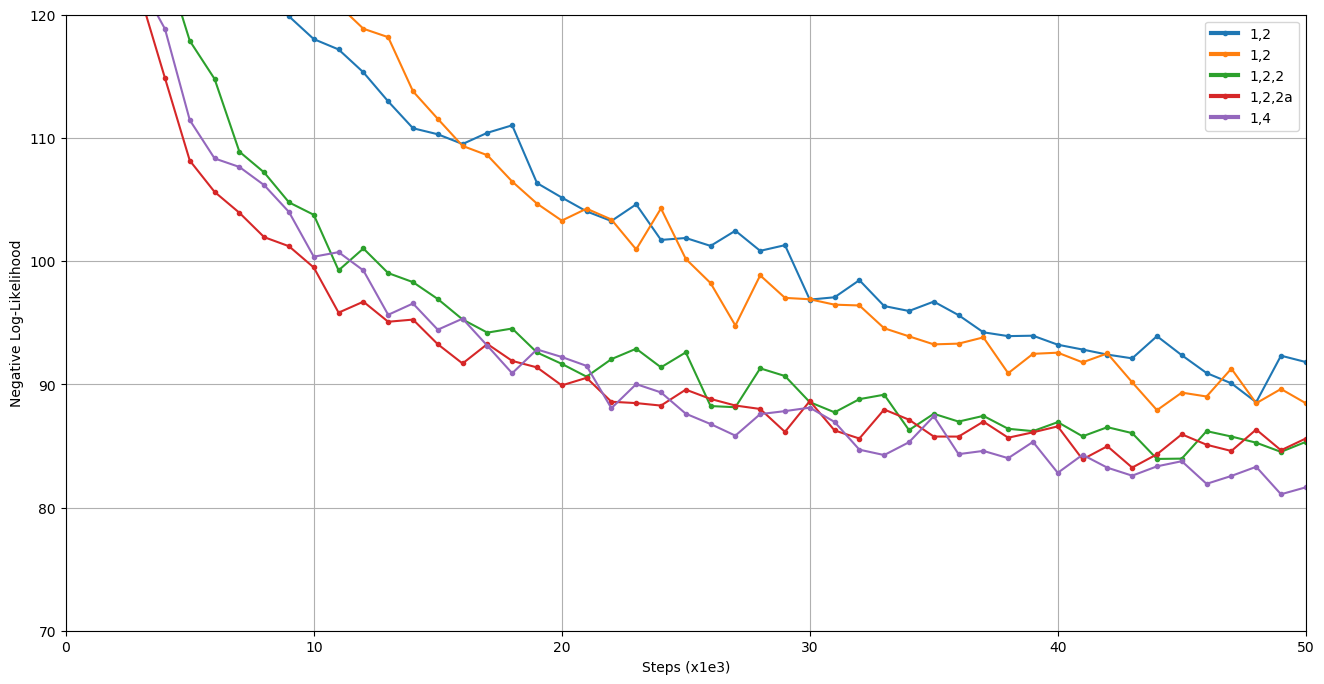

In [629]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.xlim(0,50)
plt.ylim(70,120)

plot_banded_error(mpl2, "1,2")
plot_banded_error(mpl2_2, "1,2,2") # without svrg
plot_banded_error(mpl2_2b, "1,2,2b") # without svrg, fix distr
plot_banded_error(mpl2_2a, "1,2,2a") # svrg
#plot_banded_error(mpl2_4, "1,2,4") # svrg
plot_banded_error(mpl4, "1,4")
#plot_banded_error(mpl8, "1,8")

#plot_banded_error(mpl1_2_2, "mpl1_2_2")
#plot_banded_error(mpl1_2_4, "mpl1_2_4")
#plot_banded_error(mpl1_2_4q, "mpl1_2_4q")
#plot_banded_error(mpl1_2_8, "mpl1_2_8")
#plot_banded_error(mpl1_4_2, "mpl1_4_2")
#plot_banded_error(mpl1_4_4, "mpl1_4_4")
#plot_banded_error(mpl1_8, "1,1_8")

#plot_banded_error(mpl16, "1,16")

#plot_banded_error(mpltest1, "1,1, 8/1")
#plot_banded_error(mpltest2, "1,1, 8/2")
#plot_banded_error(mpltest4, "1,1, 8/4")
#plot_banded_error(mpltest8, "1,1, 8/8")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('loss_ns.png')

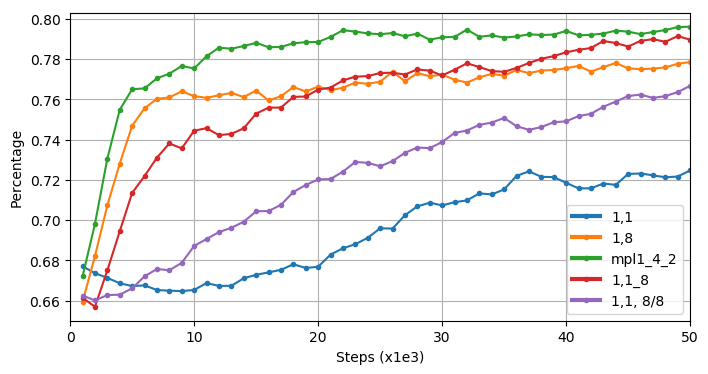

In [358]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0,50)
#plt.ylim(70,120)

plot_banded_error(mpl1_r, "1,1")
#plot_banded_error(mpl4_r, "1,4")
plot_banded_error(mpl8_r, "1,8")
plot_banded_error(mpltest1_4_2_r, "mpl1_4_2")
plot_banded_error(mpltest1_8_r, "1,1_8")
#plot_banded_error(mpl16_r, "1,16")

#plot_banded_error(mpltest1_r, "1,1, 8/1")
#plot_banded_error(mpltest2_r, "1,1, 8/2")
#plot_banded_error(mpltest4_r, "1,1, 8/4")
plot_banded_error(mpltest8_r, "1,1, 8/8")

fatlegend(ax)
plt.ylabel("Percentage")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('rand_ns.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

### Gradient estimators

In [128]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    f, f2 = ls, ls2
    m = g2
    v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:
        c2 = cv_coef(h2, nn, 2, get_weights("whh", "bhh")) if cf else tf.ones([batch_size*ns,1])        
        c = cv_coef(h, nn, 1, get_weights("wxh", "bxh")) if cf else tf.ones([batch_size,1])   
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-tf.tile(c2,[ns,1])*g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c2)*mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-tf.tile(c,[ns,1])*g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c)*mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2f, dh2g, dh2mg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("whh", "bhh"))
                             for z in [tf.stop_gradient(f2)*log_prob(_h2, sh2),
                                       tf.stop_gradient(g2)*log_prob(_h2, sh2), mg2]]
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh"))
                          for z in [tf.stop_gradient(f)*log_prob(_h, sh),
                                    tf.stop_gradient(g)*log_prob(_h, sh), mg]]
        if cf:
            b2 = bias_cor(f2, g2, _h2, sh2, nn, 2, get_weights("whh", "bhh"), nh) 
            b = bias_cor(f, g, _h, sh, nn, 1, get_weights("wxh", "bxh"), 392)
        else:
            b2 = [tf.zeros([nh,nh]), tf.zeros([1,nh])]
            b = [tf.zeros([392,nh]), tf.zeros([1,nh])]
        
        dh2, dh = [list(z) for z in dh2f], [list(z) for z in dhf]
        for j in range(2):
            dh2[j][0] = (dh2[j][0]/(dh2g[j][0]+eps)-b2[j])*dh2mg[j][0]
            dh[j][0] = (dh[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]

    gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]

    train_step = opt.apply_gradients(gd if tr is None else gd+tr)
    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1), prob(y_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

def cv_coef(p, nn, layer, w):
    p = tf.reshape(p, [ns**(layer-1), batch_size, nh])
    for i in range(ns**(layer-1)):
        pp = p[i]
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=pp, dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sls, sls_expect = stc_pass(ss, layer, nn)
        fh = det_pass(pp, layer, 1, sls_expect)
        dfh = tf.gradients(fh, pp)[0]
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, pp]]
        f = tf.stop_gradient(sls)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/(tf.reduce_sum(vg)+eps)]],[batch_size,1])
        coef = t if i==0 else tf.concat([coef, t], 0)
    return coef

def bias_cor(f, g, p, s, nn, layer, w, dim):
    ff, gg = [tf.stop_gradient(z)*log_prob(s, p) for z in [f,g]]
    _f, _g = [tf.reshape(z,[ns,ns**(layer-1)*batch_size,nh]) for z in [ff,gg]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(z[i], w), 0) for z in [_f, _g]]
        mfg, mg = [df/(dg+eps), dg] if i==0 else [mfg+df/(dg+eps), mg+dg]
        sfgg = df if i==0 else sfgg+df
    mg /= ns
    sfgg = (sfgg-mg*mfg)/(ns-1)
    b = sfgg/(mg+eps)
    return b[0:dim], b[dim]

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)